In [173]:
# ! pip install -q -U keras-tuner

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import time
# preprocessing and pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from outlier_cleaner import OutlierCleaner



# sklearn libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, RandomForestClassifier, VotingClassifier
)

# sklearn metrics
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_score, roc_auc_score
from extended_sklearn_metrics import evaluate_model_with_cross_validation

# extra model
import xgboost as xgb

import joblib

# deep learning
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow import keras

In [175]:
df = pd.read_csv('heart_attack_prediction_indonesia.csv', nrows=30000)
df1 = df.copy()

## Feature Engineering (higher values = more risk)

In [176]:
df['alcohol_consumption'] = df['alcohol_consumption'].fillna('None')
stress_mapping = {
    'Low': 1,        
    'Moderate': 2,   
    'High': 3        
}
df['stress_level'] = df['stress_level'].map(stress_mapping)
smoking_mapping = {
    'Never': 1, 
    'Past': 2, 
    'Current': 3  
}
df['smoking_status'] = df['smoking_status'].map(smoking_mapping)
alcohol_consumption_mapping = {
    'None': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['alcohol_consumption'] = df['alcohol_consumption'].map(alcohol_consumption_mapping)
physical_activity_mapping = {
    'Low': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['physical_activity'] = df['physical_activity'].map(physical_activity_mapping)
dietary_habits_mapping = {
    'Unhealthy': 1, 
    'Healthy': 2, 
}
df['dietary_habits'] = df['dietary_habits'].map(dietary_habits_mapping)
air_pollution_mapping = {
    'Low': 1, 
    'Moderate': 2, 
    'High': 3  
}
df['air_pollution_exposure'] = df['air_pollution_exposure'].map(air_pollution_mapping)
income_level_mapping = {
    'Low': 3, 
    'Middle': 2, 
    'High': 1  
}
df['income_level'] = df['income_level'].map(income_level_mapping)
df['age_group'] = np.where(
    df['age'] < 40, 1, np.where(
        df['age'] < 55, 2, np.where(
            df['age'] < 65, 3, 4 
        )
    )
)
df.age_group.unique()

array([3, 2, 4, 1])

In [177]:
df.columns.tolist()

['age',
 'gender',
 'region',
 'income_level',
 'hypertension',
 'diabetes',
 'cholesterol_level',
 'obesity',
 'waist_circumference',
 'family_history',
 'smoking_status',
 'alcohol_consumption',
 'physical_activity',
 'dietary_habits',
 'air_pollution_exposure',
 'stress_level',
 'sleep_hours',
 'blood_pressure_systolic',
 'blood_pressure_diastolic',
 'fasting_blood_sugar',
 'cholesterol_hdl',
 'cholesterol_ldl',
 'triglycerides',
 'EKG_results',
 'previous_heart_disease',
 'medication_usage',
 'participated_in_free_screening',
 'heart_attack',
 'age_group']

In [178]:
df['health_risk_score'] = (
    df['hypertension'] +
    df['diabetes'] +
    df['obesity'] +
    df['family_history'] +
    df['smoking_status'] +
    df['alcohol_consumption'] +
    (1 - df['physical_activity']) +
    (1 - df['dietary_habits']) +
    df['air_pollution_exposure'] +
    df['stress_level'] +
    df.income_level
)

# df['cholesterol ratio'] = df['cholesterol_hdl']/df['cholesterol_ldl']
# df = df.drop(labels=['cholesterol_hdl', 'cholesterol_ldl'], axis=1)
df['obesity_risk_score'] = np.where(df['gender'] == 'Male' , df['obesity'] * 1 + (df['waist_circumference'] > 102) * 0.5, df['obesity'] * 1 + (df['waist_circumference'] > 88) * 0.5)
# df = df.drop(labels=['obesity', 'waist_circumference'], axis=1)
# df['pulse_pressure'] = df['blood_pressure_systolic'] - df['blood_pressure_diastolic']
# df = df.drop(labels=['blood_pressure_systolic', 'blood_pressure_diastolic'], axis=1)
df['stress_to_sleep_ratio'] = df['stress_level'] / df['sleep_hours']
# df = df.drop(columns=['stress_level', 'sleep_hours'])
df['mean_arterial_pressure'] = (2* df['blood_pressure_systolic'] + df['blood_pressure_diastolic']) / 3 
# df = df.drop(columns=['blood_pressure_systolic', 'blood_pressure_diastolic'])
df['triglyceride-hdl-ratio'] = df['triglycerides'] / df['cholesterol_hdl']
# df = df.drop(columns=['triglycerides', 'cholesterol_hdl'])


In [179]:
# df_risk_score = df[['health_risk_score','hypertension', 'diabetes', 'obesity_risk_score', 'family_history', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'income_level']]
# df_risk_score.corr().sort_values(by='health_risk_score', ascending=False).style.background_gradient(cmap='coolwarm')

In [180]:
# df = df.drop(columns=['physical_activity', 'dietary_habits'])

In [181]:
df.isna().any()

age                               False
gender                            False
region                            False
income_level                      False
hypertension                      False
diabetes                          False
cholesterol_level                 False
obesity                           False
waist_circumference               False
family_history                    False
smoking_status                    False
alcohol_consumption               False
physical_activity                 False
dietary_habits                    False
air_pollution_exposure            False
stress_level                      False
sleep_hours                       False
blood_pressure_systolic           False
blood_pressure_diastolic          False
fasting_blood_sugar               False
cholesterol_hdl                   False
cholesterol_ldl                   False
triglycerides                     False
EKG_results                       False
previous_heart_disease            False


In [182]:
# df.health_risk_score.unique()

## Encoding

In [183]:
## Encoding
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(exclude='object')
encoder = LabelEncoder()
for cols in cat_df:
    cat_df[cols+'_encoded'] = encoder.fit_transform(cat_df[cols])
cat_df = cat_df.select_dtypes(exclude='object')
df = pd.concat([cat_df, num_df], axis=1)

## Cleaning Outliers

In [184]:
cleaner = OutlierCleaner(df, preserve_index=True)
cleaned_df, info = cleaner.clean_columns(
    method='zscore',
    show_progress=True
)
df = cleaned_df

Cleaning columns: 100%|██████████| 34/34 [00:00<00:00, 204.50it/s]


## Visualization of correlation of features with heart attack

In [185]:
df.waist_circumference.min(), df.waist_circumference.max()
# df.waist_circumference.unique()

(45, 142)

In [186]:
df.columns

Index(['gender_encoded', 'region_encoded', 'EKG_results_encoded', 'age',
       'income_level', 'hypertension', 'diabetes', 'cholesterol_level',
       'obesity', 'waist_circumference', 'family_history', 'smoking_status',
       'alcohol_consumption', 'physical_activity', 'dietary_habits',
       'air_pollution_exposure', 'stress_level', 'sleep_hours',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl',
       'triglycerides', 'previous_heart_disease', 'medication_usage',
       'participated_in_free_screening', 'heart_attack', 'age_group',
       'health_risk_score', 'obesity_risk_score', 'stress_to_sleep_ratio',
       'mean_arterial_pressure', 'triglyceride-hdl-ratio'],
      dtype='object')

In [187]:
results = []
for i in df1.columns:
    results.append({
        f'{i}': df1[i].unique()
    })
results

[{'age': array([60, 53, 62, 73, 52, 64, 49, 61, 57, 32, 34, 48, 42, 58, 44, 38, 72,
         55, 37, 56, 41, 59, 47, 51, 77, 54, 40, 31, 39, 63, 46, 67, 33, 50,
         66, 71, 25, 45, 65, 84, 68, 81, 43, 36, 70, 35, 87, 90, 82, 80, 30,
         76, 74, 29, 69, 79, 78, 27, 75, 28, 85, 86, 83, 26, 88, 89],
        dtype=int64)},
 {'gender': array(['Male', 'Female'], dtype=object)},
 {'region': array(['Rural', 'Urban'], dtype=object)},
 {'income_level': array(['Middle', 'Low', 'High'], dtype=object)},
 {'hypertension': array([0, 1], dtype=int64)},
 {'diabetes': array([1, 0], dtype=int64)},
 {'cholesterol_level': array([211, 208, 231, 202, 232, 238, 165, 186, 121, 196, 190, 234, 193,
         125, 134, 271, 185, 230, 132, 163, 200, 191, 219, 142, 180, 205,
         228, 265, 177, 192, 176, 207, 174, 225, 170, 130, 251, 201, 159,
         172, 153, 258, 221, 189, 214, 105, 255, 149, 128, 199, 131, 139,
         133, 168, 188, 285, 252, 216, 220, 212, 116, 182, 250, 175, 246,
         215,

In [188]:
results = []
for i in df.columns:
    results.append({
        f'{i}': df[i].unique() 
    })
results

[{'gender_encoded': array([1, 0])},
 {'region_encoded': array([0, 1])},
 {'EKG_results_encoded': array([1, 0])},
 {'age': array([60, 53, 62, 73, 52, 64, 49, 61, 57, 32, 34, 48, 42, 58, 38, 72, 55,
         37, 56, 41, 59, 47, 51, 77, 54, 40, 31, 39, 63, 46, 67, 33, 50, 66,
         44, 25, 45, 65, 84, 68, 71, 81, 43, 36, 70, 35, 87, 90, 82, 80, 30,
         76, 74, 29, 69, 79, 78, 27, 75, 28, 86, 85, 83, 26, 88, 89],
        dtype=int64)},
 {'income_level': array([2, 3, 1], dtype=int64)},
 {'hypertension': array([0, 1], dtype=int64)},
 {'diabetes': array([1, 0], dtype=int64)},
 {'cholesterol_level': array([211, 208, 231, 202, 232, 238, 165, 186, 121, 196, 190, 234, 193,
         125, 134, 271, 185, 132, 163, 200, 191, 219, 142, 180, 205, 228,
         265, 177, 192, 176, 207, 174, 225, 170, 130, 251, 201, 159, 172,
         153, 258, 221, 189, 214, 105, 255, 149, 128, 199, 131, 139, 133,
         168, 285, 252, 216, 220, 212, 116, 182, 250, 175, 246, 226, 240,
         210, 147, 254, 2

In [189]:
corr_df = df.corr()[['heart_attack']].sort_values(by='heart_attack', ascending=False)
corr_df.style.background_gradient(cmap='coolwarm', axis=None)

,heart_attack
heart_attack,1.000000
previous_heart_disease,0.281527
hypertension,0.266837
health_risk_score,0.197037
diabetes,0.188859
obesity,0.166300
obesity_risk_score,0.152269
smoking_status,0.141086
age,0.103794
age_group,0.103686


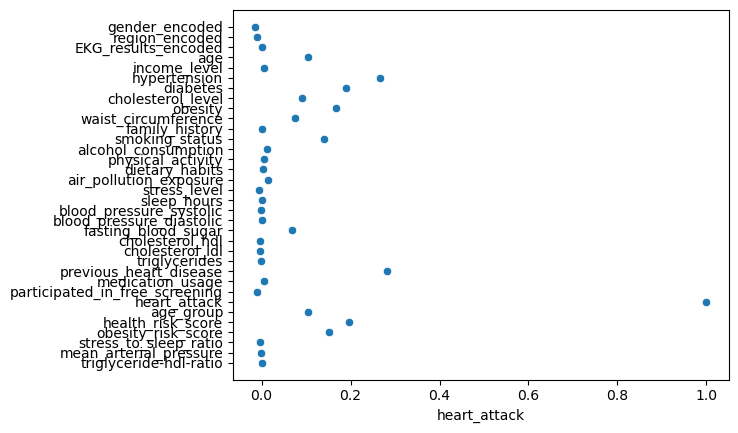

In [190]:
sns.scatterplot(data=df.corr(), x='heart_attack', y=df.columns.tolist())
plt.show()

## Modelling


In [191]:
x = df.drop('heart_attack', axis=1)
y = df['heart_attack']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)
# X_train_scaled, X_train_scaled[0]
SEED = 42
rf =  RandomForestClassifier(
    criterion='entropy',
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=3,
)
# param_grid = {
#     'classifier__criterion': ['gini', 'entropy', 'log_loss'],
#     'classifier__max_depth': [2,4,5],
#     'classifier__min_samples_split': [2, 3, 4],
#     'classifier__min_samples_leaf': [1, 2, 3],
#     'classifier__max_features': ['sqrt', 'log2'],
# }
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf),
])
# grid_search = GridSearchCV(
#     estimator = rf_pipeline,
#     param_grid = param_grid,
#     scoring = 'accuracy',
#     n_jobs = None,
#     cv = 5,
#     verbose = 2,
# )
# grid_search.fit(X_train, y_train)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# rf.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        min_samples_split=3))])

In [192]:
x.columns

Index(['gender_encoded', 'region_encoded', 'EKG_results_encoded', 'age',
       'income_level', 'hypertension', 'diabetes', 'cholesterol_level',
       'obesity', 'waist_circumference', 'family_history', 'smoking_status',
       'alcohol_consumption', 'physical_activity', 'dietary_habits',
       'air_pollution_exposure', 'stress_level', 'sleep_hours',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl',
       'triglycerides', 'previous_heart_disease', 'medication_usage',
       'participated_in_free_screening', 'age_group', 'health_risk_score',
       'obesity_risk_score', 'stress_to_sleep_ratio', 'mean_arterial_pressure',
       'triglyceride-hdl-ratio'],
      dtype='object')

In [193]:
y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      5154
           1       0.77      0.49      0.60      3461

    accuracy                           0.73      8615
   macro avg       0.74      0.69      0.70      8615
weighted avg       0.74      0.73      0.72      8615



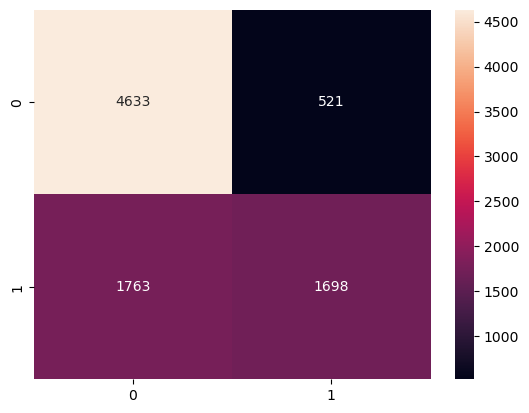

In [194]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d')
plt.show() 

## Saving model to joblib file

In [195]:
# joblib.dump(rf_pipeline, 'heart_attack_prediction_model.joblib')

## Save clean df as CSV file

In [196]:
df.to_csv('clean_hap.csv', index=False)